<a href="https://colab.research.google.com/github/yumi-h-1/Extracting-data-from-web-pages-and-PDFs/blob/main/EMA_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##This script scrapes the data of the medicine only from the first Meeting Highlights News

---

# Instruction

1. Please save this script from the box to your Google Drive before running the script.
2. Please download the medicine list from EMA web site(https://www.ema.europa.eu/en/medicines/download-medicine-data) in your 'My Drive' (https://drive.google.com/drive/my-drive). Make sure the file name to be 'medicines_output_medicines_en.xlsx'.
3. Please download the therapy area list from here () in your 'My Drive' (https://drive.google.com/drive/my-drive).
4. Please download all 'procedural steps' PDF files for existing medicines which are in the new Meeting Highlights News in the first page of EMA News web site(https://www.ema.europa.eu/en/news?f%5B0%5D=ema_news_responsible_body%3A100002). For example, the picture below is the screenshot of EMA News web site (as of 27/09/2024). You will need to download the procedural steps PDFs of existing medicines in the **first** Meeting Highlights News. (Meeting highlights from the Committee for Medicinal Products for Human Use (CHMP) 16-19 September 2024)

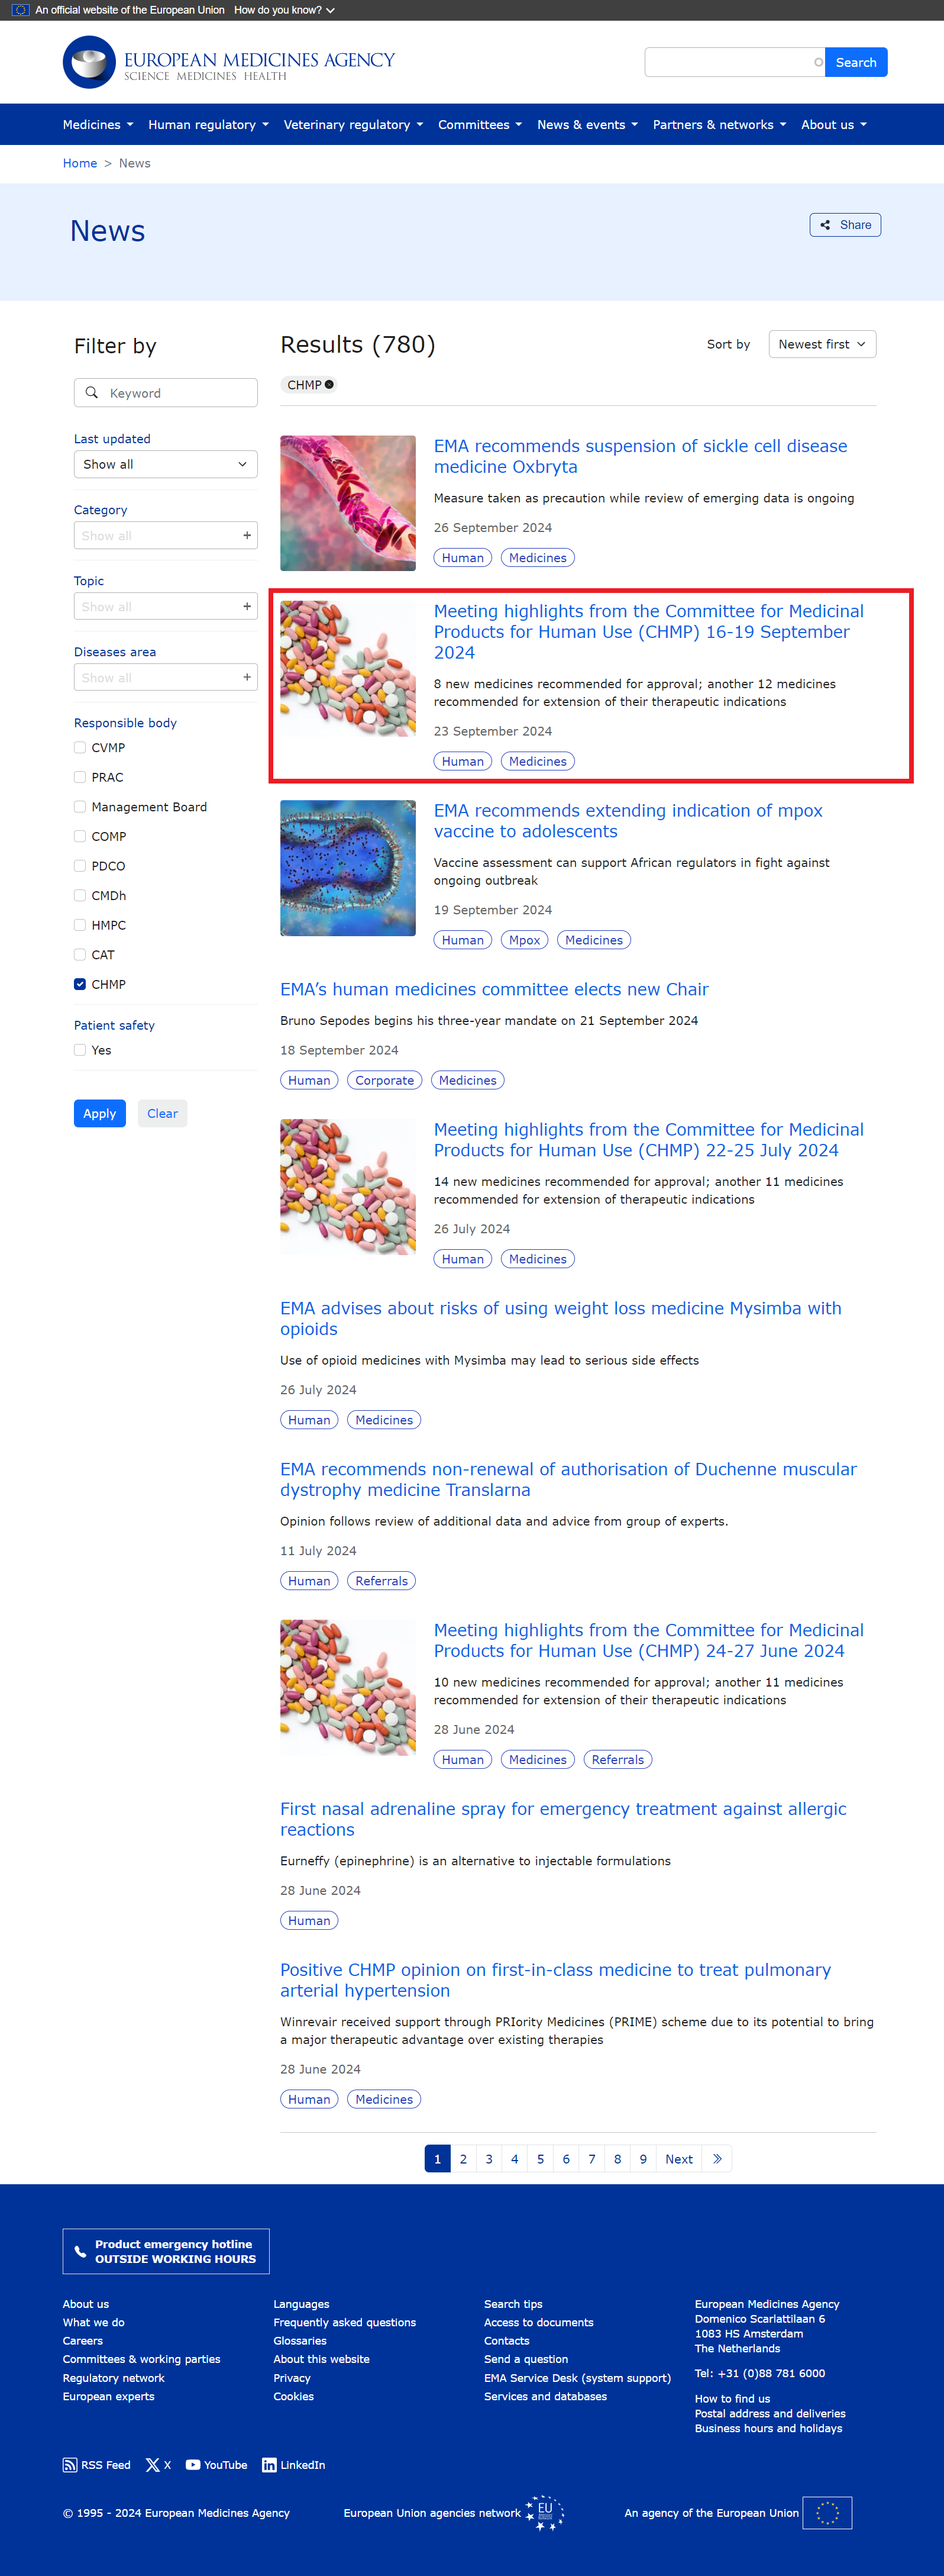

5. Create a folder named 'ema_pdf' in your 'My Drive' (https://drive.google.com/drive/my-drive). Make sure all pdf files to be stored in the folder named 'ema_pdf'. This is the screenshot where the 'ema_pdf' folder should be located.

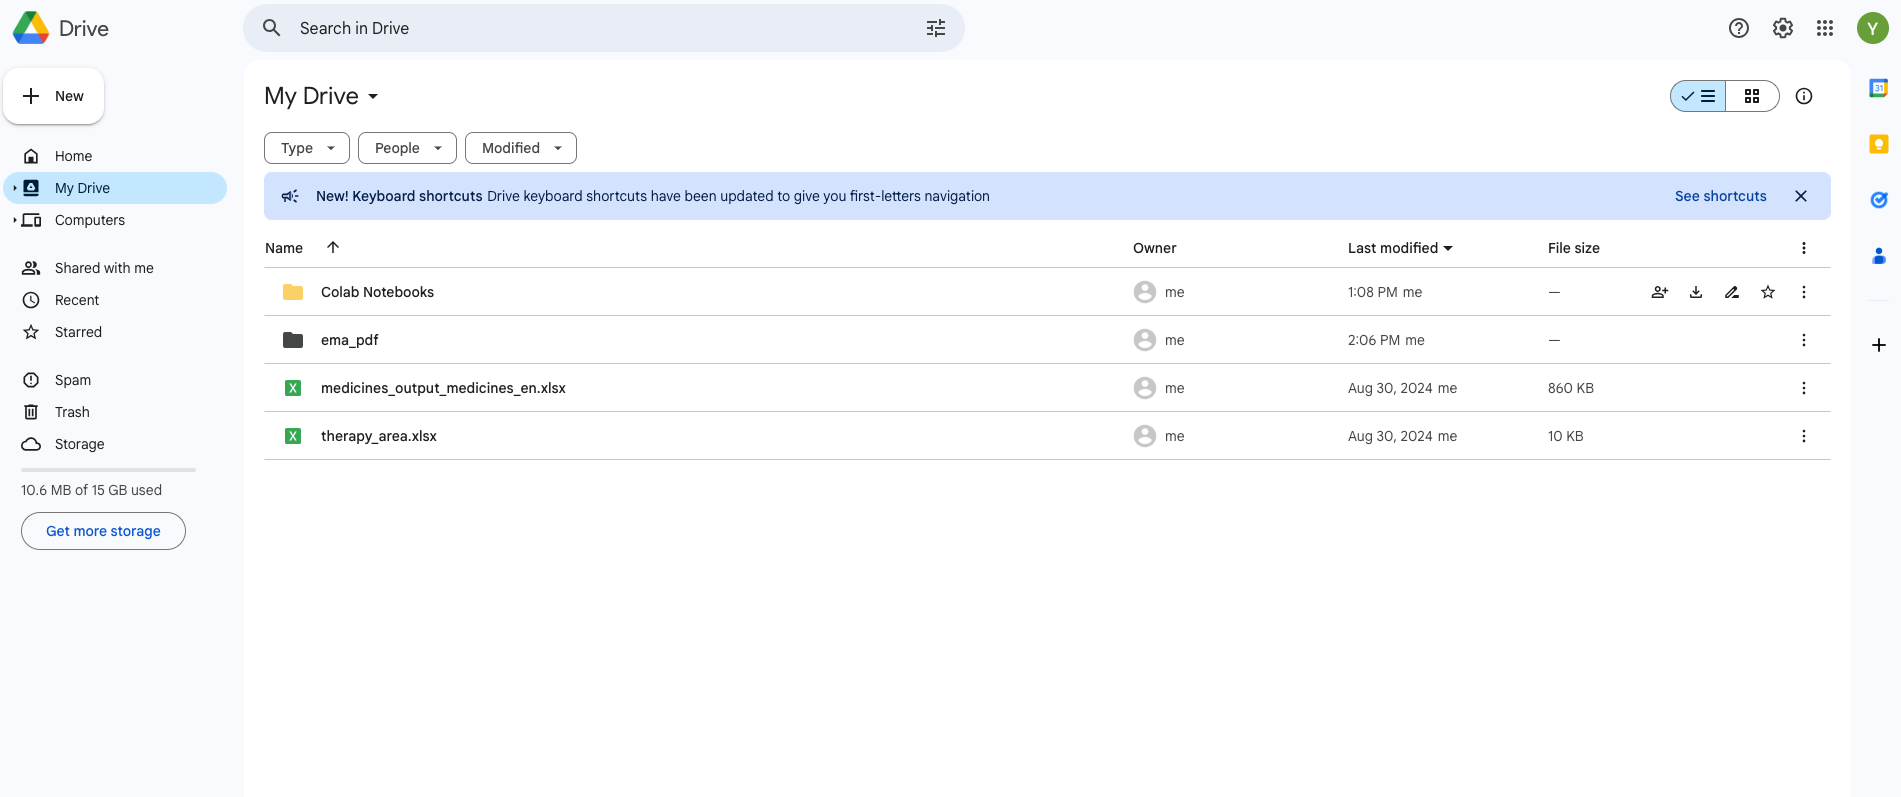

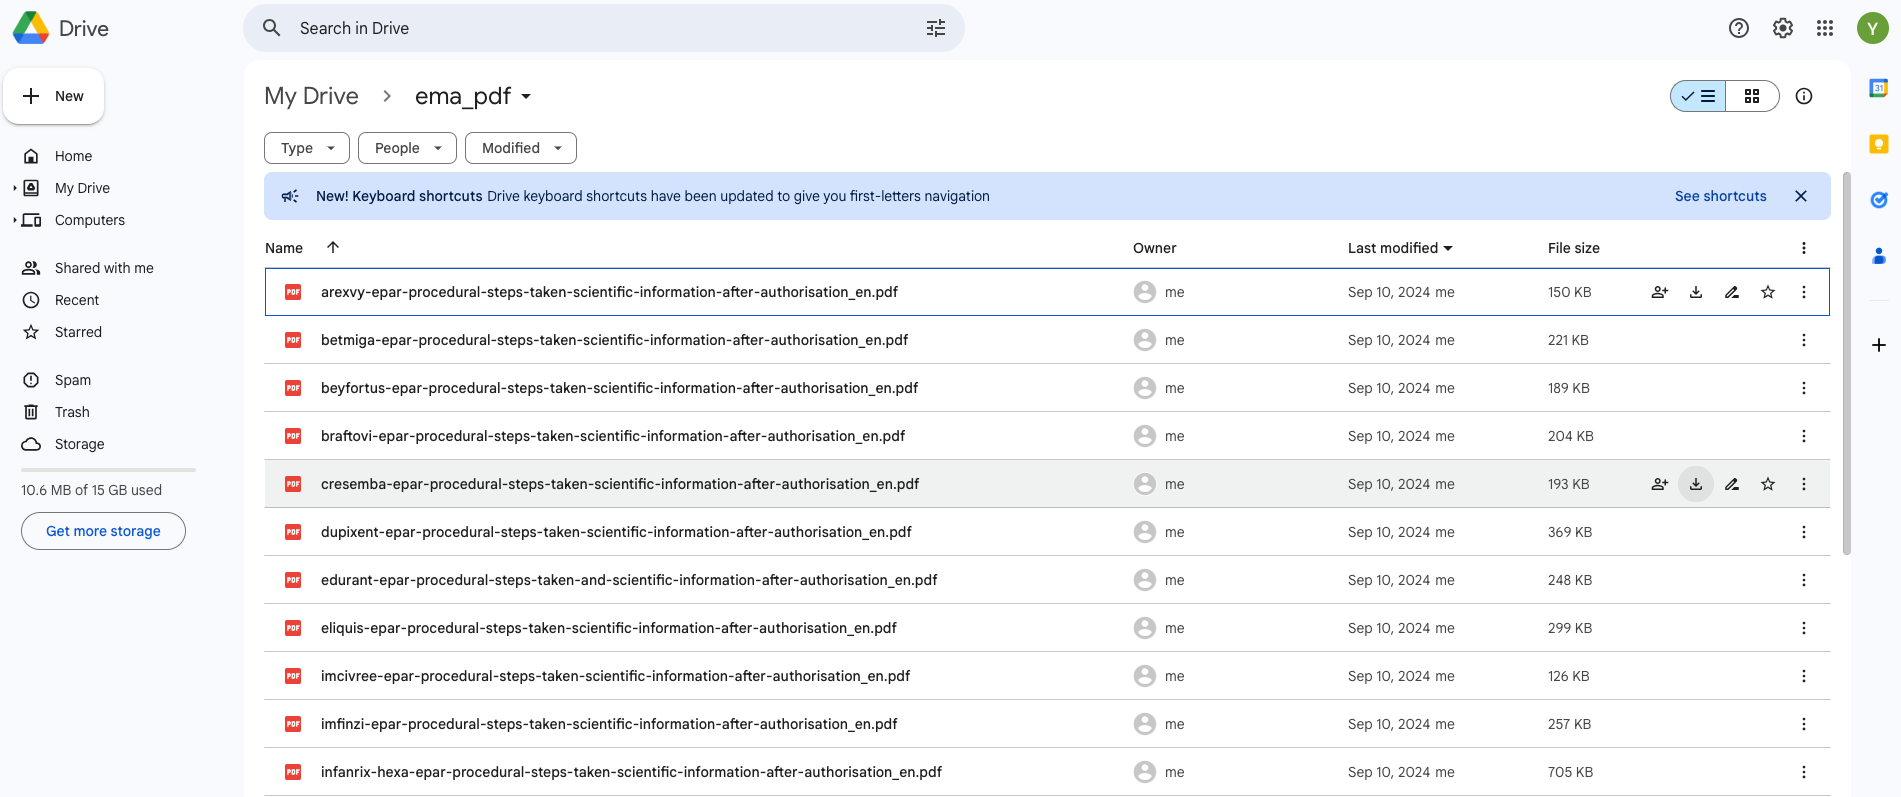

---

#Import libraries

In [ ]:
!pip install openai -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install pypdf2 -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import re
import os
import time
import random
from google.colab import drive
import pandas as pd
from datetime import datetime, timedelta
from openai import OpenAI
import PyPDF2

# Define headers for scraping web pages

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'DNT': '1',
    'Connection': 'keep-alive'
}

# Mount Google drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load the PDFs for existing medicines

In [ ]:
# Specify the directory where the PDFs are stored
pdf_directory = '/content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/ema_pdf'

# List to store the paths of PDFs
pdf_paths = []

# Loop through the directory and find all files ending with '.pdf'
for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        # Join the directory path and the filename to get the full path
        full_path = os.path.join(pdf_directory, filename)
        pdf_paths.append(full_path)

# Load the medicine list

In [ ]:
# Load the medicine list from EMA to the colab as a dataframe
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/medicines_output_medicines_en.xlsx', header=8)

In [ ]:
# Make modifications for the name of medicine to strings
df['Name of medicine'] = df['Name of medicine'].str.lower()
df['Name of medicine'] = df['Name of medicine'].str.replace(' ', '-')

# Extract the data from the medicines list

### CHMP Opinion Date / Decision date / Orphan / EMA date from medicine list

In [ ]:
# Function to scrape the data from the medicine list
def scrape_data_fromSHEET(scraped_medicine_name, dataframe, columns_to_return):
    # Search for the name in the dataframe
    matching_row = df[df['Name of medicine'] == scraped_medicine_name]

    if not matching_row.empty:
        # Extract the desired columns from the matching row
        return matching_row[columns_to_return].iloc[0].to_dict()
    else:
        return None

In [ ]:
# Function to change the format of date for CHMP opinion date
def get_chmp_opinion_date(date_str, date_format='%d %B %Y'):
    try:
        # Convert date string to datetime object
        date_obj = datetime.strptime(date_str, date_format)

        # Subtract one day to get CHMP Opinion Date
        chmp_opinion_date = date_obj - timedelta(days=1)

        # Convert back to string in the same format
        return chmp_opinion_date.strftime(date_format)
    except ValueError as e:
        # If parsing fails, print the error and return 'N/A'
        print(f"Date parsing error: {e}")
        return 'N/A'

# Load the therapy area list

In [ ]:
# Load the therapy area list as a dataframe
therapy_area_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/therapy_area.xlsx')

# Extract the data from the therapy area list

### Therapy Area

In [ ]:
# Function to scrape the therapy area
def scrape_therapy_area(scraped_therapy_class, dataframe, area_column):
    # Search for the name in the dataframe
    matching_row = therapy_area_df[therapy_area_df['Therapy Class'] == scraped_therapy_class]

    if not matching_row.empty:
        # Extract the desired columns from the matching row
        return matching_row[area_column].iloc[0]
    else:
        # Return None or an appropriate message if no match is found
        return None

# Extract the data from EPAR

### Therapy class / Cancer

#### The function linked to the therapy area list

In [ ]:
# Function to scrape the data from EPAR web pages
def scrape_data_fromEPAR(epar_url, product_data, therapy_area_df):
    try:
        epar_response = requests.get(epar_url, headers=headers)
        epar_response.encoding = 'utf-8'
        epar_soup = BeautifulSoup(epar_response.text, 'html.parser')
    except Exception as e:
        print(f"Error fetching or processing the EPAR page: {epar_url}. Error: {e}")
        product_data['Therapy class'] = 'N/A'
        product_data['Cancer'] = 'No'
        product_data['Therapy Area'] = 'N/A'
        return product_data

    # Find the ATC code and Therapy class
    try:
        atc_code_tag = epar_soup.find('dt', string=re.compile(r'Anatomical therapeutic chemical \(ATC\) code'))
        if atc_code_tag:
            atc_code = atc_code_tag.find_next('dd').get_text(strip=True)
            therapy_class = atc_code[:3]  # Only take the first three characters
            product_data['Therapy class'] = therapy_class
        else:
            # If there is no ATC code in the EPAR page, extract the code from the medicine sheet
            code_column = ['Pharmacotherapeutic group\n(human)']
            sheet_data = scrape_data_fromSHEET(product_data['Product Name'], df, code_column)

            if sheet_data and sheet_data.get('Pharmacotherapeutic group\n(human)'):
                therapy_class = sheet_data['Pharmacotherapeutic group\n(human)']
                product_data['Therapy class'] = therapy_class
            else:
                therapy_class = 'N/A'
                product_data['Therapy class'] = therapy_class
    except Exception as e:
        print(f"Error extracting ATC code or Therapy class for {epar_url}: {e}")
        product_data['Therapy class'] = 'N/A'

    # Determine if it's related to cancer
    if therapy_class in ['L01', 'L02']:
        product_data['Cancer'] = 'Yes'
    else:
        product_data['Cancer'] = 'No'

    # Match the Therapy Area using the extracted Therapy Class
    therapy_area = scrape_therapy_area(therapy_class, therapy_area_df, 'Therapy Area')
    if therapy_area:
        product_data['Therapy Area'] = therapy_area
    else:
        product_data['Therapy Area'] = 'N/A'

    return product_data

# Extract the data from NICE

### Search Result in NICE

In [ ]:
# Function to scrape data from the NICE web page using INN
def scrape_data_fromNICE(nice_url, product_data):
    nice_response = requests.get(nice_url, headers=headers)
    nice_response.encoding = 'utf-8'
    nice_soup = BeautifulSoup(nice_response.text, 'html.parser')

    # Extract the title of the webpage
    try:
        title_tag = nice_soup.find('title')
        title_text = title_tag.get_text(strip=True) if title_tag else ''
    except Exception as e:
        print(f"Error extracting title from NICE page: {nice_url}. Error: {e}")
        product_data['NICE'] = 'N/A'
        return product_data

    # Check if the title indicates no results
    if "No results" in title_text:
        product_data['NICE'] = 'N/A'
    else:
        try:
            # Extract the medicine name from the title (the part before the first '|')
            inn_common_name = title_text.split('|')[0].strip()

            # Match the extracted name with the original INN from product_data
            if re.search(re.escape(product_data['INN']), inn_common_name, re.IGNORECASE):
                product_data['NICE'] = 'Yes'
            else:
                product_data['NICE'] = 'No'
        except Exception as e:
            print(f"Error processing INN matching for NICE page: {nice_url}. Error: {e}")
            product_data['NICE'] = 'N/A'

    return product_data

# Extract the data using a LLM

### OpenAI Model API call

In [ ]:
# Set up OpenAI: If you receive a new API from OpenAI, please replace the text inside 'api_key'
client = OpenAI(api_key="000") # Removed the previous API

# Define the model
MODEL = "gpt-4o-mini"

### Full indication for all medicines

In [ ]:
# Function to query the model for full indications from HTML
def query_model_for_indication(html_content):
    query = f"""Use the HTML code provided below to answer the following question:
    Extract the full or therapeutic indication of the medicine. It may be located under the 'Overview' section or the 'Therapeutic Indication' section.

    HTML structure:
    \"\"\"
    {html_content}
    \"\"\"

    Question: What is the full or therapeutic indication of the medicine? Write the answer in the format 'Medicine Name: Full Indication'.
    If the answer cannot be found, write only 'I don't know.'."""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant who extracts complete, exact, and accurate information, especially from text."},
                {"role": "user", "content": query}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying the model: {e}")
        return "N/A"

In [ ]:
# Function to find the full indication using the query
def process_medicines_and_get_indications(epar_urls):
    indications_dict = {}  # Dictionary to store indications for each URL

    # Loop over each URL
    for epar_url in epar_urls:
        try:
            response = requests.get(epar_url, headers=headers, timeout=(3.05, 27))
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'html.parser')
            html_content = soup.prettify()

            # Query the model with the individual HTML content
            indication = query_model_for_indication(html_content)

            # Store the indication in the dictionary with the URL as its key
            indications_dict[epar_url] = indication

        except Exception as e:
            print(f"Error processing {epar_url}: {e}")
            indications_dict[epar_url] = "Error fetching or processing the page"

    return indications_dict

In [ ]:
# Store epar urls from each meeting highlights news
# Define the URL of the main page
mainpage_url = 'https://www.ema.europa.eu/en/news?f%5B0%5D=ema_news_responsible_body%3A100002'

response = requests.get(mainpage_url, headers=headers, timeout=(3.05, 27))
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, 'html.parser')

# Use the desired URL pattern
url_pattern = re.compile(r'^/en/news/meeting-highlights.*-chmp-.*')

# Initialize an empty list for URLs (can be a single variable for just the first URL)
first_subpage_url = None

# Find the first 'a' tag with the href attribute matching the pattern
for a_tag in soup.find_all('a', href=url_pattern):
    first_subpage_url = 'https://www.ema.europa.eu' + a_tag['href']
    break

# List to store EPAR URLs
epar_urls = []

news_response = requests.get(first_subpage_url, headers=headers)
news_response.encoding = 'utf-8'
news_soup = BeautifulSoup(news_response.text, 'html.parser')

# Find all sections containing product information
items = news_soup.find_all('div', class_='item')
for item in items:
    # Extract the product name
    try:
        product_name_tag = item.find('h3', class_='mb-4')
        if product_name_tag:
            product_name = product_name_tag.get_text(strip=True).lower().replace(' ', '-')
        else:
            product_name = 'N/A'
    except Exception as e:
        print(f"Error extracting product name from subpage: {subpage_url}. Error: {e}")
        product_name = 'N/A'

    if product_name != 'N/A':
        epar_url = f"https://www.ema.europa.eu/en/medicines/human/EPAR/{product_name}"
        epar_urls.append(epar_url)

# Print the number of the epar_urls
print(f"Collected {len(epar_urls)} EPAR URLs.")

Collected 20 EPAR URLs.


In [ ]:
# Store full indications
indications = process_medicines_and_get_indications(epar_urls)

### New indication for existing medicines (with HTML)

In [ ]:
# Function to query the model to find new indications from HTML
def query_model_for_new_indication_html(html_content):
    query = f"""Use the HTML code provided below to answer the following question:
    Extract all newly added indications for the medicine. The indications are related to the patient group as well.
    The newly added indications are identified within <strong></strong> tags, indicating bold text.

    HTML structure:
    \"\"\"
    {html_content}
    \"\"\"

    Question: What is the newly added indication of the medicine? Extract the words exactly as they appear in bold text.
    If there are different text formats between bold text sections, the first bold text is considered the first newly added indication, and any bold text that follows the different format will be the second newly added indication, and so on.
    Use a comma (',') to separate each bold text section when extracting them in order.
    Write the answer in the format 'Medicine Name: New Indication'.
    If the answer cannot be found, write only 'I don't know.'."""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant who extracts complete, exact, and accurate information, especially from text."},
                {"role": "user", "content": query}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying the model: {e}")
        return "N/A"

In [ ]:
# Define the URL of the main page
mainpage_url = 'https://www.ema.europa.eu/en/news?f%5B0%5D=ema_news_responsible_body%3A100002'

# Send the request to get the main page HTML
response = requests.get(mainpage_url, headers=headers, timeout=(3.05, 27))
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, 'html.parser')

# Use the desired URL pattern for the first "meeting highlights" page
url_pattern = re.compile(r'^/en/news/meeting-highlights.*-chmp-.*')

# Find the first 'a' tag with the href attribute matching the pattern
first_subpage_url = None
for a_tag in soup.find_all('a', href=url_pattern):
    first_subpage_url = 'https://www.ema.europa.eu' + a_tag['href']
    break

# List to store variation URLs
variation_urls = []

# Send the request to get the news subpage HTML
news_response = requests.get(first_subpage_url, headers=headers)
news_response.encoding = 'utf-8'
news_soup = BeautifulSoup(news_response.text, 'html.parser')

# Find all sections containing product information
items = news_soup.find_all('div', class_='item')
for item in items:
    # Also, extract variation URLs from any <a> tags in the item div
    # Find all <a> tags in the current item div
    for a_tag in item.find_all('a', href=True):
        href = a_tag['href']
        # Check if the href follows the variation URL pattern
        if href.startswith('/en/medicines/human/variation/'):
            # Construct the full URL and add to the variation_urls list
            full_variation_url = 'https://www.ema.europa.eu' + href
            variation_urls.append(full_variation_url)

# Print the collected variation URLs
print(f"Collected {len(variation_urls)} variation URLs.")

Collected 5 variation URLs.


In [ ]:
variation_urls

['https://www.ema.europa.eu/en/medicines/human/variation/cerdelga',
 'https://www.ema.europa.eu/en/medicines/human/variation/hepcludex',
 'https://www.ema.europa.eu/en/medicines/human/variation/kevzara',
 'https://www.ema.europa.eu/en/medicines/human/variation/tevimbra-0',
 'https://www.ema.europa.eu/en/medicines/human/variation/tevimbra']

In [ ]:
# Function to find the new indication in HTML using the query
def process_medicines_and_new_indications_html(variation_urls):
    new_indications_dict = {}  # Dictionary to store indications for each URL

    # Loop over each URL
    for variation_url in variation_urls:
        try:
            response = requests.get(variation_url, headers=headers, timeout=(3.05, 27))
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'html.parser')
            html_content = soup.prettify()

            # Query the model with the individual HTML content
            new_indication = query_model_for_new_indication_html(html_content)

            # Store the indication in the dictionary with the URL as its key
            new_indications_dict[variation_url] = new_indication

        except Exception as e:
            print(f"Error processing {variation_url}: {e}")
            new_indications_dict[variation_url] = "Error fetching or processing the page"

    return new_indications_dict

In [ ]:
# Store new indications from html
new_indications_html = process_medicines_and_new_indications_html(variation_urls)

In [ ]:
new_indications_html

{'https://www.ema.europa.eu/en/medicines/human/variation/cerdelga': 'Cerdelga: Paediatric population (from 6 to < 18 years of age) weighing ≥ 15 kg, Cerdelga is indicated for paediatric patients with GD1 who are 6 years and older with a minimum body weight of 15 kg, who are stable on enzyme replacement therapy (ERT), and who are CYP2D6 PMs, IMs or EMs.',
 'https://www.ema.europa.eu/en/medicines/human/variation/hepcludex': 'Hepcludex: and paediatric patients 3 years of age and older weighing at least 10 kg',
 'https://www.ema.europa.eu/en/medicines/human/variation/kevzara': 'Kevzara: Rheumatoid arthritis, Polymyalgia rheumatica',
 'https://www.ema.europa.eu/en/medicines/human/variation/tevimbra-0': 'Tevimbra: Tevimbra, in combination with platinum-based chemotherapy, is indicated for the first-line treatment of adult patients with unresectable, locally advanced or metastatic OSCC whose tumours express PD‑L1 with a tumour area positivity (TAP) score ≥ 5% (see section 5.1).',
 'https://ww

### Deleted indication for existing medicines (with HTML)

In [ ]:
# Function to query the model to find removed indications from HTML
def query_model_for_removed_indication_html(html_content):
    query = f"""Use the HTML code provided below to answer the following question:
    Extract all removed indications for the medicine. The indications are related to the patient group as well.
    The removed indications are identified within <s></s> tags, indicating strikethrough text.

    HTML structure:
    \"\"\"
    {html_content}
    \"\"\"

    Question: What is the removed indication of the medicine? Extract the words exactly as they appear in strikethrough text.
    If there are different text formats between strikethrough text sections, the first strikethrough text is considered the first removed indication, and any strikethrough text that follows the different format will be the second removed indication, and so on.
    Use a comma (',') to separate each strikethrough text section when extracting them in order.
    Write the answer in the format 'Medicine Name: Removed Indication'.
    If the answer cannot be found, write only 'I don't know.'."""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant who extracts complete, exact, and accurate information, especially from text."},
                {"role": "user", "content": query}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying the model: {e}")
        return "N/A"

In [ ]:
# Function to find the removed indication in HTML using the query
def process_medicines_and_removed_indications_html(variation_urls):
    removed_indications_dict = {}  # Dictionary to store indications for each URL

    # Loop over each URL
    for variation_url in variation_urls:
        try:
            response = requests.get(variation_url, headers=headers, timeout=(3.05, 27))
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'html.parser')
            html_content = soup.prettify()

            # Query the model with the individual HTML content
            removed_indications = query_model_for_removed_indication_html(html_content)

            # Store the indication in the dictionary with the URL as its key
            removed_indications_dict[variation_url] = removed_indications

        except Exception as e:
            print(f"Error processing {epar_url}: {e}")
            removed_indications_dict[variation_url] = "Error fetching or processing the page"

    return removed_indications_dict

In [ ]:
# Store removed indications
removed_indications_html = process_medicines_and_removed_indications_html(variation_urls)

In [ ]:
removed_indications_html

{'https://www.ema.europa.eu/en/medicines/human/variation/cerdelga': "I don't know.",
 'https://www.ema.europa.eu/en/medicines/human/variation/hepcludex': "I don't know.",
 'https://www.ema.europa.eu/en/medicines/human/variation/kevzara': "I don't know.",
 'https://www.ema.europa.eu/en/medicines/human/variation/tevimbra-0': "I don't know.",
 'https://www.ema.europa.eu/en/medicines/human/variation/tevimbra': "I don't know."}

### EMA date for existing medicines (with PDFs)

In [ ]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    try:
        with open(pdf_path, "rb") as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in range(len(reader.pages)):
                text += reader.pages[page].extract_text()
        return text
    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return ""

In [ ]:
# Function to query the model to find the date of the recent new indication from PDFs
def query_model_for_ema_date(pdf_text):
    query = f"""Use the document stored in the variable 'pdf_text' to answer the following question. If the answer cannot be found, write 'N/A'.
    Extract only the most recent added indication for the medicine. The date criteria should be 'Commission \nDecision \nIssued2 / \namended'.
    The newly added indication may be stated as 'Extension of indication' or something similar.

    PDF content: {pdf_text}

    Question: What is the commision decision issued date of the newly added indication for the medicine in the variable 'pdf_text'?
    Answer only the date in DD/MM/YYYY format."""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant who extracts complete, exact, and accurate information, especially from text."},
                 {"role": "user", "content": query}]
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying the model: {e}")
        return "N/A"

### New indication for existing medicines (with PDFs)

In [ ]:
# Function to query the model to find new indications from PDFs
def query_model_for_new_indication_pdf(pdf_text):
    query = f"""Use the document stored in the variable 'pdf_text' to answer the following question:
    Extract only the most recent added indication for the medicine. The date criteria is 'Commission \nDecision \nIssued2 / \namended'.
    The newly added indication may be stated between 'Extension of indication' and 'Change(s) to therapeutic indication'.

    PDF content: {pdf_text}

    Question: What is the most recent added indication for the medicine in the variable 'pdf_text'?
    Write the answer in the format 'Medicine Name: Newly added Indication'.
    If the answer cannot be found, write 'I don't know.'."""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant who extracts complete, exact, and accurate information, especially from text."},
                 {"role": "user", "content": query}]
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying the model: {e}")
        return "N/A"

# Extract the data from the Meeting Highlights news

### Product Name / INN / Initial Approval / Marketing authorisation holder

#### The function linked to EPAR medicines data and medicines list

In [ ]:
def scrape_data_fromMH_with_LLM(newspage_url, pdf_paths, therapy_area_df, df, indications):
    # Request for HTML of the given URL
    news_response = requests.get(newspage_url, headers=headers)
    news_response.encoding = 'utf-8'
    news_soup = BeautifulSoup(news_response.text, 'html.parser')

    # Find all sections
    items = news_soup.find_all('div', class_='item')

    # Prepare a list to store extracted data
    product_data_list = []
    current_recommendation = None

    for item in items:
        try:
            # Check if this item is a recommendation heading
            heading_tag = item.find('h2', class_='mb-4 rounded-title')
            if heading_tag:
                heading_text = heading_tag.get_text(strip=True).lower()
                if 'positive recommendations on new medicines' in heading_text:
                    current_recommendation = 'Positive'
                    initial_approval = 'Initial approval'
                elif 'positive recommendations on new therapeutic indications' in heading_text:
                    current_recommendation = 'Positive'
                    initial_approval = 'Extension'
                elif 'positive recommendations on extensions of indications' in heading_text:
                    current_recommendation = 'Positive'
                    initial_approval = 'Extension'
                elif 'positive recommendations on extensions of therapeutic indications' in heading_text:
                    current_recommendation = 'Positive'
                    initial_approval = 'Extension'
                else:
                    current_recommendation = None  # Ignore other sections
                continue

            # Skip items if the current recommendation is not positive
            if current_recommendation != 'Positive':
                continue

            # Extract the product name
            product_name_tag = item.find('h3', class_='mb-4')
            if product_name_tag:
                product_name = product_name_tag.get_text(strip=True).lower()  # Convert to lowercase
                product_name = product_name.replace(' ', '-')  # Replace spaces with hyphens
            else:
                product_name = 'N/A'

            # Construct the EPAR URL using the product name
            epar_url = f"https://www.ema.europa.eu/en/medicines/human/EPAR/{product_name}"
            #variation_url = f"https://www.ema.europa.eu/en/medicines/human/variation/{product_name}"

            matching_variation_urls = [url for url in variation_urls if url.split('/')[-1].startswith(product_name)]
            if not matching_variation_urls:
                matching_variation_urls = [f"https://www.ema.europa.eu/en/medicines/human/variation/{product_name}"]

            # Initialize a dictionary for this product
            product_data = {
                'Product Name': product_name,
                'Recommendation': current_recommendation,
                'Initial Approval': initial_approval,
                'Date for extension': 'N/A',
                'Full indication': 'N/A',
                'New indication HTML': 'N/A',
                'Removed indication HTML': 'N/A',
                'epar_url': epar_url,
                'variation_url': matching_variation_urls
            }

            # Extract additional data from the EPAR page
            try:
                product_data = scrape_data_fromEPAR(epar_url, product_data, therapy_area_df)
            except Exception as e:
                print(f"Error scraping data from EPAR for {product_name}: {e}")

            # Match the EPAR URL with the indication dictionary
            if epar_url in indications:
                product_data['Full indication'] = indications[epar_url]
            else:
                product_data['Full indication'] = 'N/A'

            # Match the variation URL with the new indication dictionary
            product_data['New indication HTML'] = ', '.join(
                [new_indications_html.get(url, 'N/A') for url in matching_variation_urls]
            )

            #if matching_variation_urls in new_indications_html:
            #    product_data['New indication HTML'] = new_indications_html[matching_variation_urls]
            #else:
            #    product_data['New indication HTML'] = 'N/A'

            product_data['Removed indication HTML'] = ', '.join(
                [removed_indications_html.get(url, 'N/A') for url in matching_variation_urls]
            )

            # Match the variation URL with the removed indication dictionary
            #if matching_variation_urls in removed_indications_html:
            #    product_data['Removed indication HTML'] = removed_indications_html[matching_variation_urls]
            #else:
            #    product_data['Removed indication HTML'] = 'N/A'

            # Extract the INN or Common name
            inn_tag = item.find('dt', string=re.compile(r'International non-proprietary name \(INN\)|INN'))
            common_name_tag = item.find('dt', string=re.compile(r'Common name'))
            if inn_tag:
                product_data['INN'] = inn_tag.find_next('dd').get_text(strip=True)
                inn_name = product_data['INN']
                # Construct the NICE URL using the medicine name
                nice_url = f'https://www.nice.org.uk/search?q={inn_name}'
                try:
                    product_data = scrape_data_fromNICE(nice_url, product_data)
                except Exception as e:
                    print(f"Error scraping data from NICE for {inn_name}: {e}")

            elif common_name_tag:
                product_data['INN'] = common_name_tag.find_next('dd').get_text(strip=True)
                common_name = product_data['INN']
                # Construct the NICE URL using the medicine name
                nice_url = f'https://www.nice.org.uk/search?q={common_name}'
                try:
                    product_data = scrape_data_fromNICE(nice_url, product_data)
                except Exception as e:
                    print(f"Error scraping data from NICE for {common_name}: {e}")

            else:
                product_data['INN'] = 'N/A'

            # Extract the Marketing-authorisation applicant
            #applicant_tag = item.find('dt', string=re.compile(r'Marketing-authorisation applicant'))
            applicant_tag = item.find('dt', string=re.compile(r'Marketing[- ]authorisation applicant', re.IGNORECASE))
            holder_tag = item.find('dt', string=re.compile(r'Marketing-authorisation applicant', re.IGNORECASE))
            if applicant_tag:
                product_data['Marketing authorisation holder'] = applicant_tag.find_next('dd').get_text(strip=True)
            elif holder_tag:
                product_data['Marketing authorisation holder'] = holder_tag.find_next('dd').get_text(strip=True)
            else:
                product_data['Marketing authorisation holder'] = 'N/A'

            # Match with the data from the dataframe
            dataframe_columns = ['Orphan medicine', 'European Commission decision date']
            try:
                dataframe_data = scrape_data_fromSHEET(product_name, df, dataframe_columns)
                if dataframe_data:
                    product_data.update(dataframe_data)
            except Exception as e:
                print(f"Error matching data from sheet for {product_name}: {e}")

            # Find the PDF corresponding to this product
            matching_pdf = next((pdf for pdf in pdf_paths if product_name in pdf.lower()), None)
            if matching_pdf:
                print(f"Processing PDF: {matching_pdf} for product: {product_name}")
                try:
                    pdf_text = extract_text_from_pdf(matching_pdf)
                    # Query the model for EMA date from the PDF
                    ema_date = query_model_for_ema_date(pdf_text)

                    # If the product is an extension, update 'EMA date'
                    if product_data['Initial Approval'] == 'Extension':
                        product_data['Date for extension'] = ema_date
                    else:
                        product_data['Date for extension'] = 'N/A'

                    new_indication_pdf = query_model_for_new_indication_pdf(pdf_text)

                    # If the product is an extension, update 'New indication PDF'
                    if product_data['Initial Approval'] == 'Extension':
                        product_data['New indication PDF'] = new_indication_pdf
                    else:
                        product_data['New indication PDF'] = 'N/A'

                except Exception as e:
                    print(f"Error processing PDF {matching_pdf} for {product_name}: {e}")

            # Add the product data to the list
            product_data_list.append(product_data)

        except Exception as e:
            print(f"Error processing item: {e}")

    return product_data_list

# Collect the data of the product

## Collect the data including EPAR data only from the first page

In [ ]:
# Define the URL of the website
mainpage_url = 'https://www.ema.europa.eu/en/news?f%5B0%5D=ema_news_responsible_body%3A100002'

# Request for HTML of the given URL
response = requests.get(mainpage_url, headers=headers, timeout=(3.05, 27))
response.encoding = 'utf-8'

# Create soup object
soup = BeautifulSoup(response.text, 'html.parser')

with open('EMA_data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = [
        'title',
        'date',
        'MH_url',
        'epar_url',
        'variation_url',
        'Product Name',
        'INN',
        'Initial Approval',
        'Cancer',
        'Orphan',
        'Therapy class',
        'Therapy Area',
        'Marketing authorisation holder',
        'Full Indication',
        'New indication HTML',
        'New indication PDF',
        'Removed indication HTML',
        'CHMP Opinion Date',
        'Decision date',
        'EMA date for extension',
        'Search Result in NICE',
        'NICE_url'
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Use the desired URL pattern
    url_pattern = re.compile(r'^/en/news/meeting-highlights.*-chmp-.*')

    # Find the first 'a' tag with the href attribute matching the pattern
    for a_tag in soup.find_all('a', href=url_pattern):
        try:
            # Try to extract the title
            title = a_tag.get_text(strip=True)

            # Try to find the date tag and extract the date
            date_tag = a_tag.find_next('time')
            date = date_tag.get_text(strip=True) if date_tag else 'N/A'

            # Construct the subpage URL
            subpage_url = 'https://www.ema.europa.eu' + a_tag['href']

            # You should define `get_chmp_opinion_date` or use another date extraction method
            chmp_opinion_date_str = get_chmp_opinion_date(date)  # Implement this function as needed

            # Scrape data from the Meeting Highlights page and process PDFs using the new function
            scrape_data_fromMH_list = scrape_data_fromMH_with_LLM(subpage_url, pdf_paths, therapy_area_df, df, indications)

            # For each product, also scrape data from the NICE website and write to CSV
            for product_data in scrape_data_fromMH_list:
                try:
                    # Extract the product name from the dataframe
                    df_name_column = ['Name of medicine']
                    medicine_name_data = scrape_data_fromSHEET(product_data['Product Name'], df, df_name_column)

                    if product_data.get('INN'):
                        inn = product_data['INN']

                        # Construct the NICE URL using the INN
                        nice_url = f'https://www.nice.org.uk/search?q={inn}'
                        product_data['NICE_url'] = nice_url

                        # Scrape NICE data and update product data
                        try:
                            product_data = scrape_data_fromNICE(nice_url, product_data)
                        except Exception as e:
                            print(f"Error scraping data from NICE for {inn}: {e}")

                    # Write the product data to the CSV
                    writer.writerow({
                        'title': title,
                        'date': date,
                        'MH_url': subpage_url,
                        'epar_url': product_data['epar_url'],
                        'variation_url': product_data['variation_url'],
                        'Product Name': product_data['Product Name'],
                        'INN': product_data['INN'],
                        'Initial Approval': product_data['Initial Approval'],
                        'Full Indication': product_data.get('Full indication', 'N/A'),
                        'New indication HTML': product_data.get('New indication HTML', 'N/A'),
                        'New indication PDF': product_data.get('New indication PDF', 'N/A'),
                        'Removed indication HTML': product_data.get('Removed indication HTML', 'N/A'),
                        'Cancer': product_data.get('Cancer', 'N/A'),
                        'Orphan': product_data.get('Orphan medicine', 'N/A'),
                        'Marketing authorisation holder': product_data['Marketing authorisation holder'],
                        'CHMP Opinion Date': chmp_opinion_date_str,
                        'Decision date': product_data.get('European Commission decision date', 'N/A'),
                        'Therapy class': product_data.get('Therapy class', 'N/A'),
                        'Therapy Area': product_data.get('Therapy Area', 'N/A'),
                        'EMA date for extension': product_data.get('Date for extension', 'N/A'),
                        'Search Result in NICE': product_data.get('NICE', 'N/A'),
                        'NICE_url': product_data.get('NICE_url', 'N/A')
                    })

                except Exception as e:
                    print(f"Error processing product data for product: {product_data['Product Name']}. Error: {e}")

            print(f"Processed the URL: {subpage_url}")

            break  # Stop after processing the first URL

        except Exception as e:
            print(f"Error processing the link: {a_tag['href']}. Error: {e}")

print("The CSV file has been saved.")

Processing PDF: /content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/ema_pdf/cerdelga-epar-procedural-steps-taken-scientific-information-after-authorisation_en.pdf for product: cerdelga
Processing PDF: /content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/ema_pdf/hepcludex-epar-procedural-steps-taken-and-scientific-information-after-authorisation_en.pdf for product: hepcludex
Processing PDF: /content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/ema_pdf/kevzara-epar-procedural-steps-taken-scientific-information-after-authorisation_en.pdf for product: kevzara
Processing PDF: /content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages and PDFs/ema_pdf/tevimbra-epar-procedural-steps-taken-scientific-information-after-authorisation_en.pdf for product: tevimbra
Processing PDF: /content/drive/MyDrive/Colab Notebooks/OHE project_Extracting data from web pages an

#Similarity of indications between EMA and NICE

In [ ]:
# Load the csv file written to a dataframe
ema_data_df = pd.read_csv('/content/EMA_data.csv')

In [ ]:
# Create dataframes for full indication, new indication from HTML, new indication from PDF and NICE url
Full_Indication = ema_data_df[['Full Indication', 'NICE_url']]
New_Indication_HTML = ema_data_df[['New indication HTML', 'NICE_url']]
New_Indication_PDF = ema_data_df[['New indication PDF', 'NICE_url']]
Nice_url = ema_data_df['NICE_url']

In [ ]:
# Function to scrape text from each NICE url
def text_fromNICE(Nice_url_list):
    nice_text_dict = {}

    for NICE_url in Nice_url_list:
        try:
            # Send the request and parse the response
            nice_response = requests.get(NICE_url, headers=headers, timeout=(3.05, 27))
            nice_response.encoding = 'utf-8'
            nice_soup = BeautifulSoup(nice_response.text, 'html.parser')

            # Extract the text content from the NICE page
            nice_text = nice_soup.get_text(separator=' ', strip=True)

            # Store the text in the dictionary with the corresponding URL
            nice_text_dict[NICE_url] = nice_text

        except Exception as e:
            print(f"Error processing {NICE_url}: {e}")
            # Store an error message in the dictionary in case of failure
            nice_text_dict[NICE_url] = "Error fetching or processing the page"

    return nice_text_dict

In [ ]:
# Store the extracted text and the NICE url
nice_text_dict = text_fromNICE(Nice_url)

In [ ]:
# Function to query the model for text similarity between NICE text and indication from a dataframe
def query_model_for_NICE_similarity(nice_text, indication):
    query = f"""Compare the following two pieces of text and determine if they mention the same therapeutic indication for the medicine:

    NICE text:
    \"\"\"{nice_text}\"\"\"

    Full Indication:
    \"\"\"{indication}\"\"\"

    Are there any matching therapeutic indications in both texts?
    Answer only 'Yes' or 'No' and provide any matching terms if applicable.
    """

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are an expert assistant who specializes in comparing medical texts and identifying therapeutic indications."},
                {"role": "user", "content": query}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying the model: {e}")
        return "N/A"

In [ ]:
# Loop to compare each NICE text with the corresponding indications in a dataframe
def compare_nice_and_indication(nice_text_dict, indication_df):
    similarity_results = []  # List to store the results

    # Iterate over the NICE URLs and corresponding indications
    for url, nice_text in nice_text_dict.items():
        try:
            # Fetch the corresponding indications from the DataFrame
            if url in indication_df['NICE_url'].values:
                indication = indication_df.loc[indication_df['NICE_url'] == url].values[0]

                # Query the model for similarity
                result = query_model_for_NICE_similarity(nice_text, indication)

                # Store the result with URL and result
                similarity_results.append({
                    'NICE_url': url,
                    'Result': result
                })
            else:
                similarity_results.append({
                    'NICE_url': url,
                    'Result': 'No matching indication found in DataFrame'
                })

        except Exception as e:
            print(f"Error processing comparison for {url}: {e}")
            similarity_results.append({
                'NICE_url': url,
                'Result': 'Error'
            })

    return similarity_results

In [ ]:
# Call the function to compare NICE texts with Full Indications
full_ind_similarity_results = compare_nice_and_indication(nice_text_dict, Full_Indication)

In [ ]:
# Call the function to compare NICE texts with New_Indication_HTML
new_ind_html_similarity_results = compare_nice_and_indication(nice_text_dict, New_Indication_HTML)

In [ ]:
# Call the function to compare NICE texts with New_Indication_PDF
new_ind_pdf_similarity_results = compare_nice_and_indication(nice_text_dict, New_Indication_PDF)

In [ ]:
# Convert the result lists to dictionaries with NICE_url as keys and results as values
full_ind_dict = {result['NICE_url']: result['Result'] for result in full_ind_similarity_results}
new_ind_html_dict = {result['NICE_url']: result['Result'] for result in new_ind_html_similarity_results}
new_ind_pdf_dict = {result['NICE_url']: result['Result'] for result in new_ind_pdf_similarity_results}

In [ ]:
# Define functions to map the results to the dataframe rows based on NICE_url
def get_full_ind_similarity(nice_url):
    return full_ind_dict.get(nice_url, 'N/A')

def get_new_ind_html_similarity(nice_url):
    return new_ind_html_dict.get(nice_url, 'N/A')

def get_new_ind_pdf_similarity(nice_url):
    return new_ind_pdf_dict.get(nice_url, 'N/A')

In [ ]:
# Apply the functions to create new columns in ema_data_df
ema_data_df['Full Indication Similarity'] = ema_data_df['NICE_url'].apply(get_full_ind_similarity)
ema_data_df['New Indication HTML Similarity'] = ema_data_df['NICE_url'].apply(get_new_ind_html_similarity)
ema_data_df['New Indication PDF Similarity'] = ema_data_df['NICE_url'].apply(get_new_ind_pdf_similarity)

#Write the EMA dataset to an .xlsx file.

In [ ]:
ema_data_df.to_excel('final_EMA_dataset.xlsx', index=False)